# FarTrend Customer Segmentation and Recommendation System


## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces challenges in personalizing marketing efforts and predicting future purchasing behavior, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year. This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

## Part 1: Data Quality and Customer Understanding 

#### P1.1 Exploratory data analysis of the data.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit

In [3]:
#Loading the data
df =  pd.read_excel('../data/FarTrend_eRetail.xlsx')

In [4]:
#Dataset overview
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Dataset Overview
- **Entries**: 541,909
- **Columns**: 8

Columns Summary:
- **InvoiceNo**: Object type, contains invoice numbers. Represents multiple items per transaction.
- **StockCode**: Object type, product code for each item.
- **Description**: Object type, product descriptions. Some missing values (540,455 non-null).
- **Quantity**: Integer, quantity of products per transaction.
- **InvoiceDate**: Datetime, date and time of transaction.
- **UnitPrice**: Float, unit price of products.
- **CustomerID**: Float, customer ID for transactions. Significant missing values (406,829 non-null).
- **Country**: Object type, country of transaction.

Preliminary Inferences:
- Missing values in **Description** and **CustomerID** need attention.
- **InvoiceDate** in datetime format aids time series analysis.
- Multiple transactions possible per customer.

Next Steps:
- Address missing and potentially erroneous data.
- Preprocessing for data cleaning and feature creation.

In [7]:
#SUMMARY STATISTICS
# Summary statistics for numerical variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The extreme values in Quantity and UnitPrice suggest the presence of significant outliers or data entry errors that need to be addressed. For example, negative values in UnitPrice could indicate refunds or cancellations, and extreme values in both Quantity and UnitPrice could distort analyses.
The difference in count between the total transactions and those with a non-null CustomerID highlights missing customer information in a substantial number of transactions, which could impact customer-specific analyses.

In [8]:
#categorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


**Data Insights**

Quantity
- **Average**: 9.55 per transaction.
- **Range**: -80995 to 80995. Negative values indicate returns/cancellations.
- **Standard Deviation**: Large, indicating significant spread and presence of outliers.

UnitPrice
- **Average**: 4.61.
- **Range**: -11062.06 to 38970. Negative values suggest errors.
- **Outliers**: Indicated by a large gap between the 75th percentile and maximum values.

CustomerID
- **Non-null Entries**: 406,829. Missing values present.
- **ID Range**: 12346 to 18287.

InvoiceNo
- **Unique Invoices**: 25,900.
- **Most Frequent**: Invoice 573585 appears 1,114 times.

StockCode
- **Unique Codes**: 4,070.
- **Most Frequent**: Code 85123A appears 2,313 times.

Description
- **Unique Descriptions**: 4,223.
- **Most Frequent**: "WHITE HANGING HEART T-LIGHT HOLDER" appears 2,369 times.
- **Missing Values**: Present and need attention.

Country
- **Unique Countries**: 38.
- **Dominance**: 91.4% of transactions are from the United Kingdom.


Product Popularity: The 'WHITE HANGING HEART T-LIGHT HOLDER' is identified as the most popular product. This insight could be valuable for inventory and marketing strategies.
Customer Base: The vast majority of transactions are from the United Kingdom, highlighting the importance of this market to FarTrend. However, the presence of 37 other countries in the dataset indicates a significant international customer base that could be explored for expansion or targeted marketing.
Data Integrity: The slight discrepancy between the number of unique stock codes and descriptions suggests some data cleaning may be needed to standardize product information.

In [9]:
#DATA CLEANING
#Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
#calculating the percentage of missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

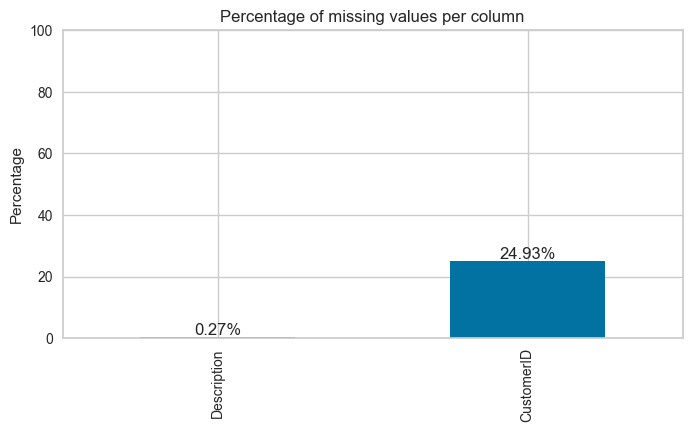

In [11]:
#VISUALIZING THE MISSING VALUES
plt.figure(figsize=(8, 4))
missing_percentage.plot(kind='bar')
plt.title('Percentage of missing values per column')
plt.ylim(0, 100)
plt.ylabel('Percentage')

for i in range(missing_percentage.shape[0]):
    plt.text(i, missing_percentage[i], f'{missing_percentage[i]:.2f}%', ha='center', va='bottom')
plt.show()

`CustomerID` (24.93% Missing Values)
The CustomerID column is pivotal for our analysis, being the key to linking purchase patterns to individual customers for clustering and personalized recommendations. With a substantial 24.93% of CustomerID values missing, the potential impact on the analysis could be significant. Imputing this large proportion of missing identifiers could introduce a high degree of bias and inaccuracies, undermining the validity of our customer segmentation and predictive modeling efforts.

Chosen Approach:

**Exclusion of Incomplete Records:** Given the importance of CustomerID in our analysis and the high proportion of missing values, we have chosen to exclude records with missing CustomerIDs. This decision prioritizes the accuracy and integrity of our customer-level analysis, ensuring that subsequent models are built on reliable and complete data.

`Description` (0.27% Missing Values)
The Description field has a relatively minor incidence of missing data. Despite the low percentage, closer inspection reveals inconsistencies in the data — the same StockCode does not consistently correspond to the same Description, indicating potential data quality issues.

Chosen Approach:

**Removal of Records with Missing Descriptions:** In light of the inconsistencies and the negligible proportion of missing Description data, we opt to remove these records. This maintains the overall quality and reliability of our dataset and ensures that our analysis is not compromised by underlying data entry errors.

In [12]:
#Removing the rows with missing values
df = df.dropna()

In [13]:
#check for misisng values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
#HANDLING DUPLICATES
#Checking for duplicates
df.duplicated().sum()

5225

In [15]:
duplicates = df[df.duplicated()]
duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


Duplicate Records Strategy

Due to the nature of our dataset, the presence of rows that are completely identical across all fields, including transaction times, is likely indicative of data entry errors rather than legitimate, repeated transactions. Such duplicates can skew our analysis by introducing noise and inaccuracies, especially when developing customer segmentation and product recommendation systems.

**Action Plan:**

To ensure the integrity of our analysis and the accuracy of our models, we will remove these duplicate rows from our dataset. This step is crucial for:

- **Enhancing Data Quality**: Ensuring that our dataset reflects unique transactions, thereby providing a more accurate view of customer behavior.
- **Improving Model Accuracy**: Cleaner data leads to more reliable clustering and predictions, essential for our goal of personalized customer engagement and effective product recommendations.

By purifying our dataset of these duplicates, we pave the way for more precise insights and actionable strategies.

In [16]:
#removing the duplicates
df = df.drop_duplicates()

In [17]:
df.shape

(401604, 8)

In [18]:
#EDA OF THE CATEGORICAL VARIABLES: InvoiceNo, StockCode, Description, Country

In [19]:
#InvoiceNo
df['InvoiceNo'].value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C560912      1
560913       1
560917       1
572879       1
553049       1
Name: InvoiceNo, Length: 22190, dtype: int64